In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py
import sys
import os
import glob
import warnings
from pprint import pprint
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

basedir = '/project/vitelli/jonathan/REDO_fruitfly/'
sys.path.insert(0, os.path.join(basedir, 'release'))

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['font.size'] = 6

warnings.filterwarnings('ignore')

In [164]:
from train_myosin_translation import MaskedVAE
from utils.vae.convnext_models import VAE

vae = MaskedVAE(in_channels=4, 
                  out_channels=2, 
                  num_latent=64, 
                  stage_dims=[[32,32], [64,64], [128,128], [256,256]])
info = torch.load('../../tb_logs/May2024/MaskedVAE_sqh_beta=0.001_split=embryo')
info = torch.load('../../tb_logs/May2024/MaskedVAE_sqh_beta=0.0001_split=embryo')

info = torch.load('../../tb_logs/May2024/MaskedVAE_sqh_beta=0.0001_split=embryo_WTTwist')
vae.load_state_dict(info['state_dict'])
vae = vae.double().to(device).eval();

def v_model(t, y):
    y = y.reshape([-1, 5, 236, 200])[:, :4]
    return VAE.forward(vae, y)[0]

(31, 2, 2, 236, 200) (31, 2, 236, 200) (31,)
Initializing
Using torchdiffeq solver


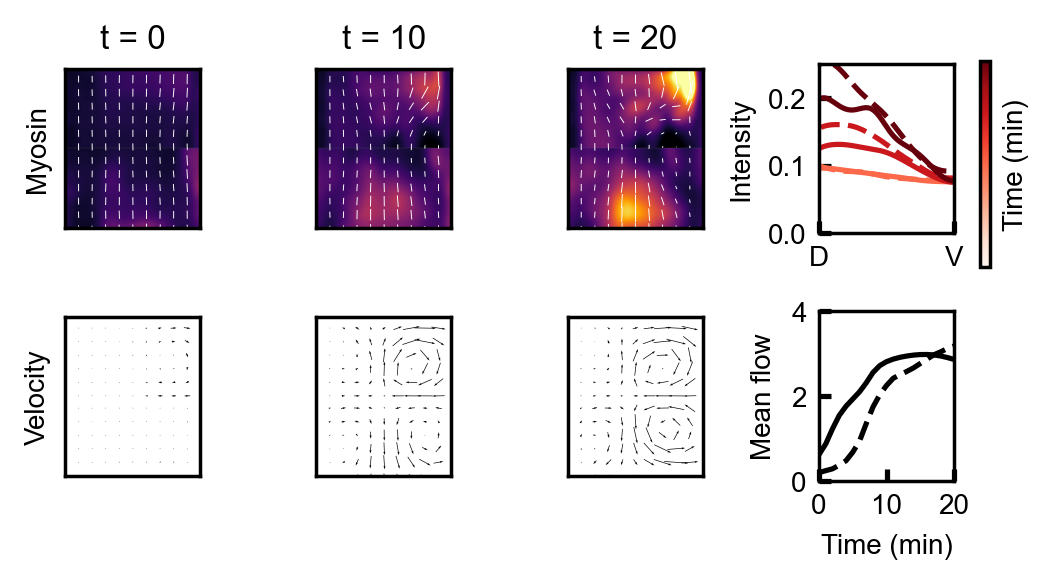

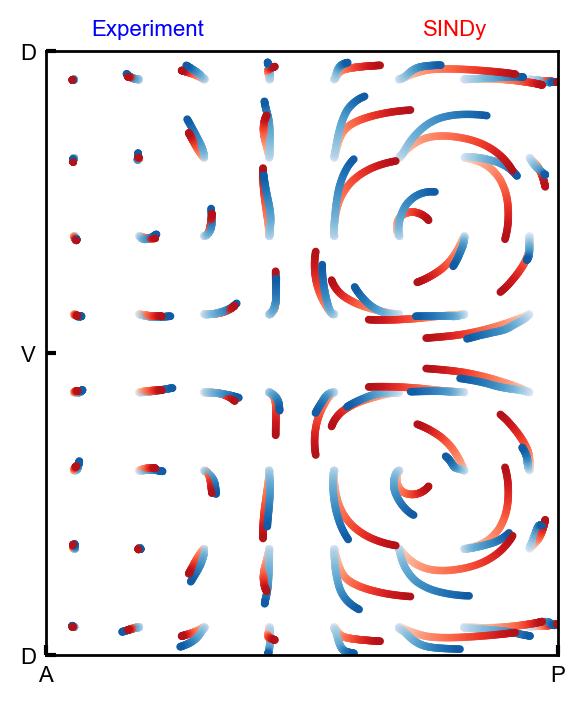

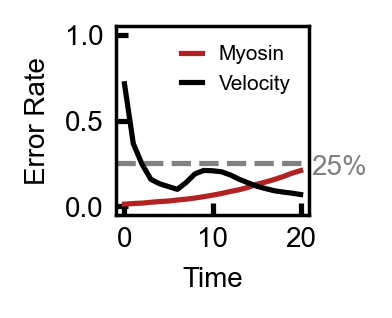

In [165]:
import torch
from utils.forecasting.closed_loop import ClosedFlyLoop
from plotting import sqh_vel_plot, trajectory_plot, residual_plot

from mutant_datasets import *

#Collect initial conditions - m, c, v, and time
m0 = np.load('../Figures/Forecasting/m0.npy')
v0 = np.load('../Figures/Forecasting/v0.npy')
s0 = np.load('../Figures/Forecasting/c0.npy')
t0 = np.load('../Figures/Forecasting/time.npy')

print(m0.shape, v0.shape, t0.shape)

y0 = np.concatenate([
    m0[0].reshape([4, 236, 200]),
    s0[0].reshape([1, 236, 200])
])
y0 = torch.from_numpy(y0)

model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)
sqh_vel_plot(t0[10:], m[10:], m0[10:], v[10:], v0[10:], mmin=0.05, mmax=0.30)
trajectory_plot(v0[10:], v[10:])
residual_plot(t0[10:], m[10:], m0[10:], v[10:], v0[10:])

100%|██████████| 6/6 [00:00<00:00, 18.42it/s]


(31, 2, 2, 236, 200) (31, 2, 236, 200) (31,)
Initializing
Using torchdiffeq solver


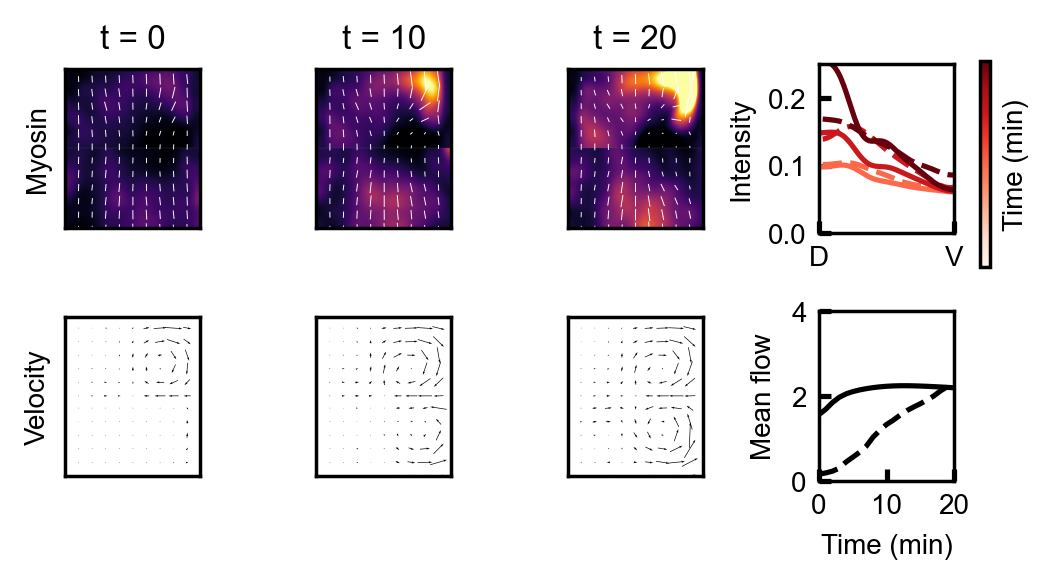

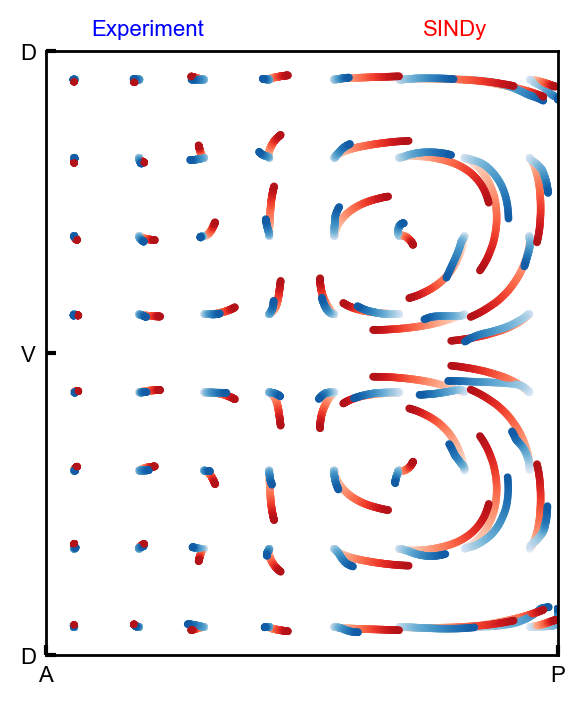

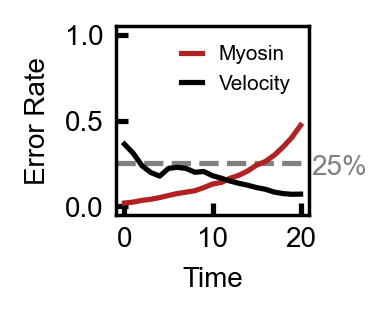

In [167]:
dataset = TwistDataset(tmin=-10, tmax=20)
m0, v0, t0 = dataset.get_trajectory(202007301030)
print(m0.shape, v0.shape, t0.shape)

y0 = np.concatenate([
    m0[0].reshape([4, 236, 200]),
    s0[0].reshape([1, 236, 200]),
])
y0 = torch.from_numpy(y0)

model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)
sqh_vel_plot(t0[10:], m[10:], m0[10:], v[10:], v0[10:], mmin=0.05, mmax=0.30)
trajectory_plot(v0[10:], v[10:])
residual_plot(t0[10:], m[10:], m0[10:], v[10:], v0[10:])

In [168]:
dataset = TollDataset(tmin=0, tmax=30)
m0, v0, t0 = dataset.get_trajectory(201712192000)
t0 -= 10
print(m0.shape, v0.shape, t0.shape)

y0 = np.concatenate([
    m0[0].reshape([4, 236, 200]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
y0 = torch.from_numpy(y0)

model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)
sqh_vel_plot(t0, m, m0, v, v0)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)

 70%|███████   | 7/10 [00:00<00:00,  7.09it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/project/vitelli/jonathan/REDO_fruitfly/flydrive.synology.me/Public/dynamic_atlas/Atlas_Data/toll[RM9]/Sqh-GFP/202101111920/tensor2D.npy'

100%|██████████| 4/4 [00:00<00:00, 285.29it/s]


(31, 2, 2, 236, 200) (31, 2, 236, 200) (31,)
Initializing
Using torchdiffeq solver
0.012166166215642751 0.060948221998297955


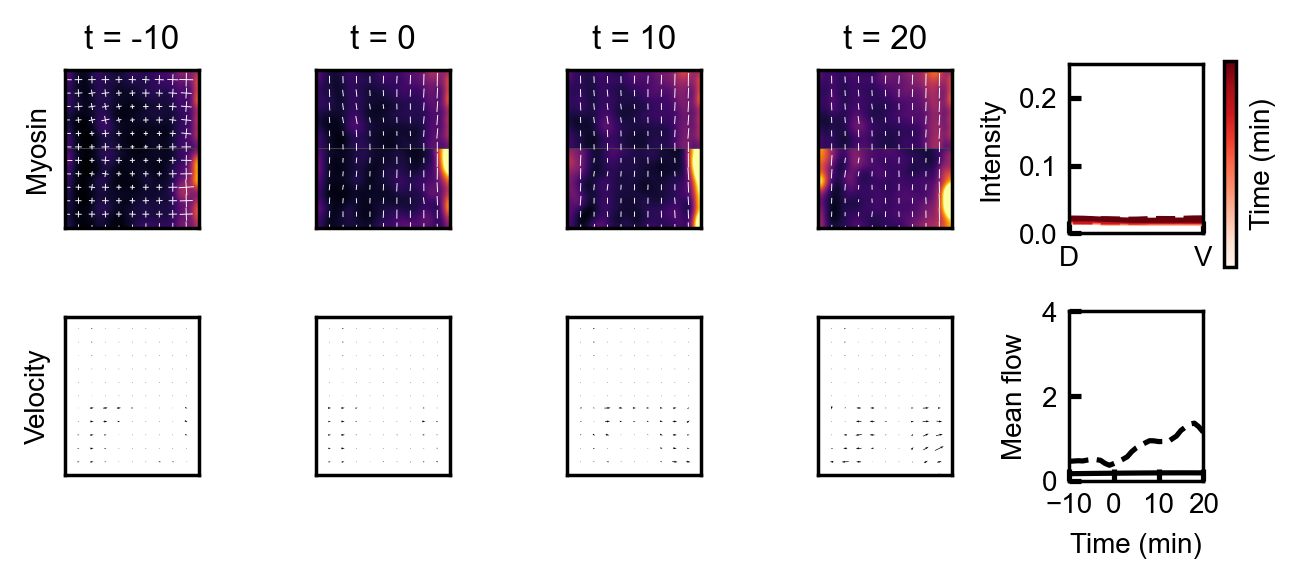

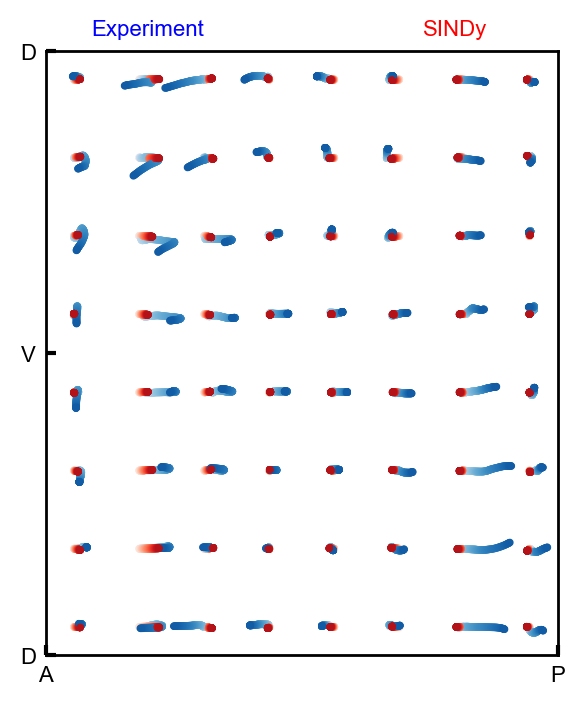

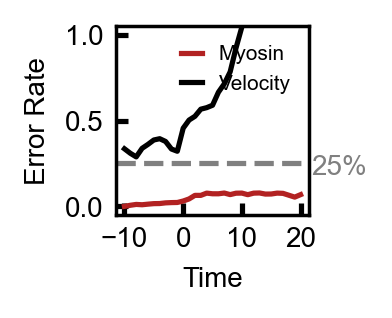

In [103]:
dataset = SpaetzleDataset(tmin=15, tmax=45)
m0, v0, t0 = dataset.get_trajectory(201712201930)
t0 -= 25
print(m0.shape, v0.shape, t0.shape)

y0 = np.concatenate([
    m0[0].reshape([4, 236, 200]),
    0.1 * (s0[0].reshape([1, 236, 200]) - np.mean(s0[0])) + np.mean(s0[0]),
])
y0 = torch.from_numpy(y0)

model = ClosedFlyLoop(v_model, sigma=5)
model.fit(y0[None])

m, s, v = model.integrate(y0.to(device), t0)
sqh_vel_plot(t0, m, m0, v, v0)
trajectory_plot(v0, v)
residual_plot(t0, m, m0, v, v0)